In [60]:
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
import ta
import numpy as np
import matplotlib.pyplot as plt
# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Calculate similarity between two time series
def calculate_similarity(current_data, past_data):
    min_length = min(len(current_data), len(past_data))
    current_data = current_data[:min_length]
    past_data = past_data[:min_length]
    
    # Normalize the data
    current_data = (current_data - np.mean(current_data)) / np.std(current_data)
    past_data = (past_data - np.mean(past_data)) / np.std(past_data)
    
    return mean_squared_error(current_data, past_data)



# Calibrate indicators
def calibrate_indicators(data, rsi_window, sma_window, ema_window,bollinger_window, stoch_window):
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], rsi_window).rsi()
    data['SMA'] = ta.trend.sma_indicator(data['Close'], sma_window)
    data['EMA'] = ta.trend.EMAIndicator(data['Close'], ema_window).ema_indicator()
    data['Bollinger'] = ta.volatility.BollingerBands(data['Close'], bollinger_window).bollinger_mavg()
    data['Stochastic'] = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], stoch_window).stoch()



def find_similar_periods(ticker, current_start_date, current_end_date, past_start_year, past_end_year, step_months, top_n=5):
    current_data = get_stock_data(ticker, current_start_date, current_end_date)
    
    similar_periods = {}
    
    for year in range(past_start_year, past_end_year + 1):
        for month in range(1, 13, step_months):
            start_date = pd.Timestamp(year=year, month=month, day=1)
            end_date = start_date + pd.DateOffset(months=3)  # Do not subtract 1 day
            
            if end_date > current_end_date:
                continue
            
            try:
                past_data = get_stock_data(ticker, start_date, end_date)
                similarity_score = calculate_similarity(current_data['Close'], past_data['Close'])
                similar_periods[(start_date, end_date)] = similarity_score
            except Exception as e:
                print(f"Failed to get data for period {start_date} to {end_date}: {e}")
    
    ranked_periods = sorted(similar_periods.items(), key=lambda x: x[1])
    
    return ranked_periods[:top_n]


def calculate_profit(actual_data, predicted_data, indicator, init_price):
    # use plot to show the actual and predicted data
    # Find the first non-NaN value in predicted_data
    start_index = predicted_data.first_valid_index()

    # Synchronize actual_data with predicted_data
    actual_data = actual_data.loc[start_index:]
    # Now plot the actual and predicted data
    # The Y should 5 not 10

    plt.title(indicator)
    plt.plot(actual_data, label='Actual')
    plt.plot(predicted_data, label='Predicted')
    plt.legend()
    plt.show()

    # Calculate the profit
    profit = 0
    bought = False
    for i in range(1, len(actual_data)):
        if predicted_data.iloc[i] > actual_data.iloc[i] and not bought:
            bought = True
            profit -= actual_data.iloc[i]

        elif predicted_data.iloc[i] < actual_data.iloc[i] and bought:
            bought = False
            profit += actual_data.iloc[-1]
    if bought:
        profit += actual_data.iloc[-1]
    
    # Calculate the final price
    final_price = init_price + profit

    return profit, final_price



# Predict prices using the single-period SMA
def predict_prices(data, sma_window):
    data['SMA'] = ta.trend.sma_indicator(data['Close'], sma_window)
    predicted_prices = data['SMA']  # Use the single-period SMA directly
    return predicted_prices


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

The 1st most similar year period is: (Timestamp('2023-01-01 00:00:00'), Timestamp('2023-04-01 00:00:00'))


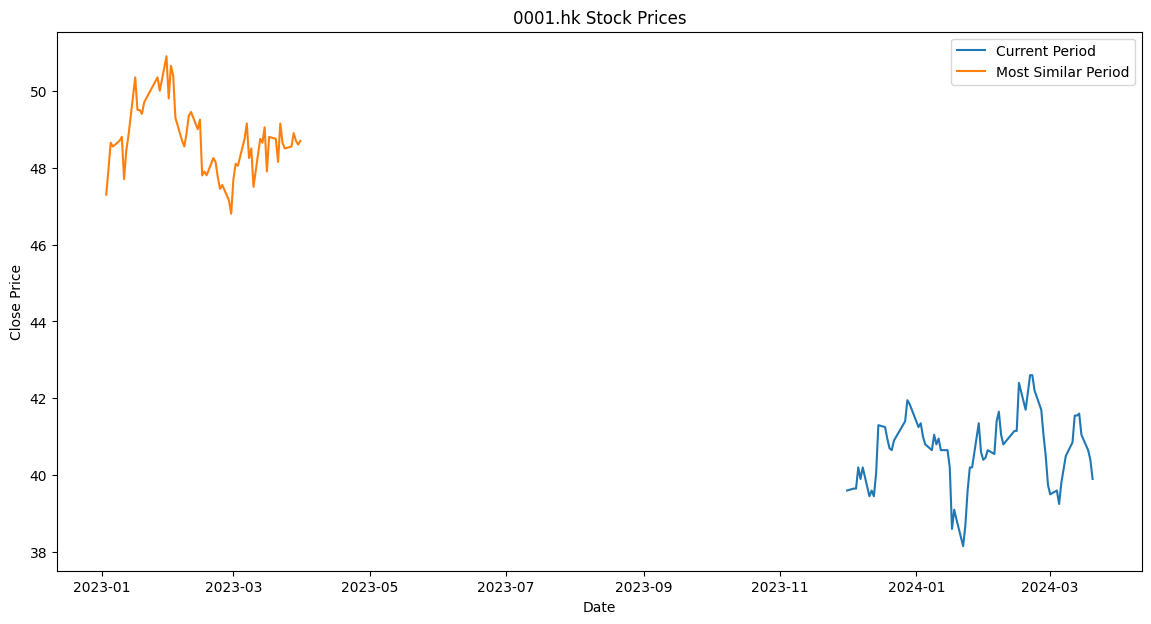

The 2nd most similar year period is: (Timestamp('2017-01-01 00:00:00'), Timestamp('2017-04-01 00:00:00'))
The 3rd most similar year period is: (Timestamp('2021-01-01 00:00:00'), Timestamp('2021-04-01 00:00:00'))
The 4th most similar year period is: (Timestamp('2017-07-01 00:00:00'), Timestamp('2017-10-01 00:00:00'))
The 5th most similar year period is: (Timestamp('2019-10-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))


In [61]:
# Example usage
ticker_symbol = input("Enter the ticker symbol: ")
# The current_start and current_end should be user input
current_start = pd.Timestamp(year=2023, month=12, day=1)
current_end = pd.Timestamp(year=2024, month=3, day=21)
past_start_year = 2014
past_end_year = 2024
step_months = 3

similar_periods = find_similar_periods(ticker_symbol, current_start, current_end, past_start_year, past_end_year, step_months)
for i, period in enumerate(similar_periods, 1):
    print(f"The {i}{'' if i == 0 else 'st' if i == 1 else 'nd' if i == 2 else 'rd' if i == 3 else 'th'} most similar year period is:", period[0])

    # The most simliar period is the first period
    if ( i == 1):
         #Fetch the data for the two periods
        data_current = get_stock_data(ticker_symbol, current_start, current_end)
        # period[0][0] is the start date and period[0][1] is the end date
        data_similar = get_stock_data(ticker_symbol, period[0][0], period[0][1])

        # Plot the closing prices for the current period
        plt.figure(figsize=(14, 7))
        plt.plot(data_current.index, data_current['Close'], label='Current Period')

        # Plot the closing prices for the most similar period
        plt.plot(data_similar.index, data_similar['Close'], label='Most Similar Period')

        plt.title(f'{ticker_symbol} Stock Prices')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()


In [62]:
# Select the top similar period for calibration
top_period = similar_periods[0][0]
top_data = get_stock_data(ticker_symbol, top_period[0], top_period[1])



[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

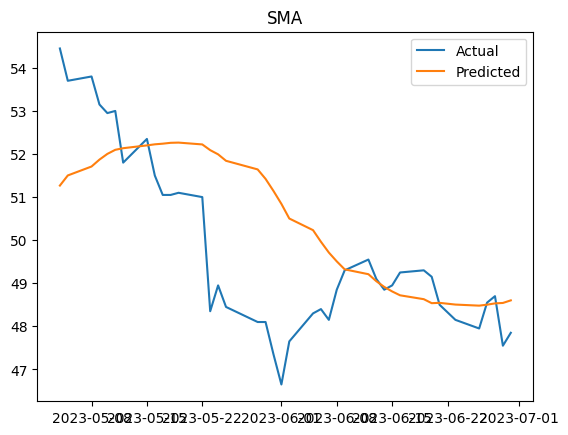

Profit with calibrated SMA: 1.1999969482421875
Final price with calibrated SMA: 1001.1999969482422


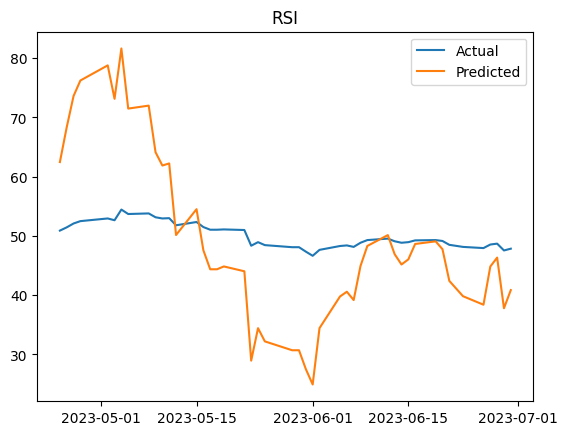

Profit with calibrated RSI: -4.200000762939453
Final price with calibrated RSI: 995.7999992370605


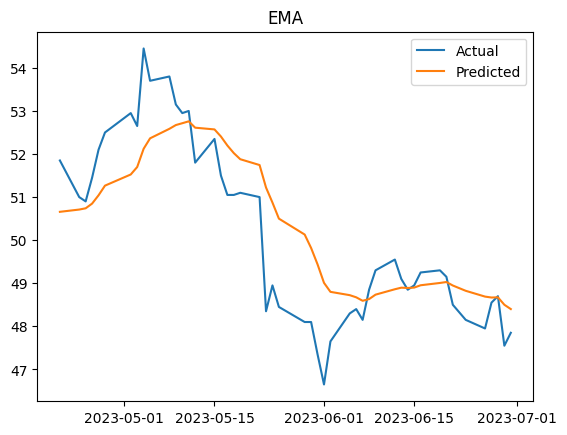

Profit with calibrated EMA: -3.8500022888183594
Final price with calibrated EMA: 996.1499977111816


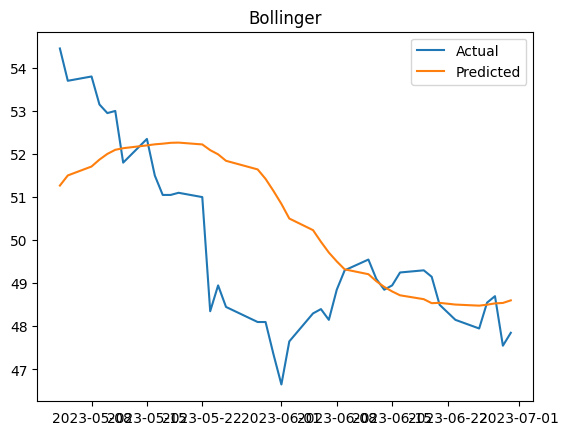

Profit with calibrated Bollinger Bands: 1.1999969482421875
Final price with calibrated Bollinger Bands: 1001.1999969482422


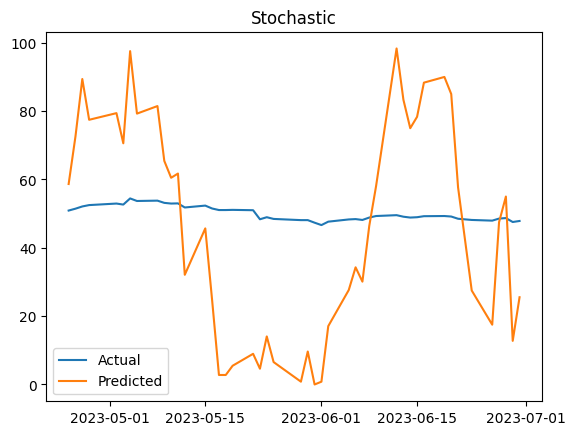

Profit with calibrated Stochastic Oscillator: -4.200000762939453
Final price with calibrated Stochastic Oscillator: 995.7999992370605


Date
2023-04-03          NaN
2023-04-04          NaN
2023-04-06          NaN
2023-04-11          NaN
2023-04-12          NaN
2023-04-13          NaN
2023-04-14          NaN
2023-04-17          NaN
2023-04-18          NaN
2023-04-19          NaN
2023-04-20          NaN
2023-04-21          NaN
2023-04-24          NaN
2023-04-25    62.467691
2023-04-26    68.350919
2023-04-27    73.614791
2023-04-28    76.234351
2023-05-02    78.786030
2023-05-03    73.147481
2023-05-04    81.638545
2023-05-05    71.494251
2023-05-08    71.993935
2023-05-09    64.125362
2023-05-10    61.884145
2023-05-11    62.239456
2023-05-12    50.155156
2023-05-15    54.514251
2023-05-16    47.587776
2023-05-17    44.373345
2023-05-18    44.373345
2023-05-19    44.853352
2023-05-22    44.034932
2023-05-23    28.956298
2023-05-24    34.430933
2023-05-25    32.203837
2023-05-29    30.706544
2023-05-30    30.706544
2023-05-31    27.525997
2023-06-01    24.930495
2023-06-02    34.440916
2023-06-05    39.781205
2023-06-06 

In [63]:
# Calibrate indicators
rsi_window = 14
sma_window = 20
ema_window = 12
bollinger_window = 20
stoch_window = 14
init_price = 1000

calibrate_indicators(top_data, rsi_window, sma_window, ema_window,bollinger_window, stoch_window)

# Evaluate performance with past future periods
future_start = top_period[1] + pd.DateOffset(days=1)
future_end = future_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
future_data = get_stock_data(ticker_symbol, future_start, future_end)

predicted_prices = predict_prices(future_data, sma_window)
actual_prices = future_data['Close']

# Evaluate performance for SMA, EMA, MACD, RSI, Bollinger Bands, Stochastic Oscillator, and ATR
sma_profit, sma_final_price = calculate_profit(actual_prices, predicted_prices, "SMA", init_price)
print(f"Profit with calibrated SMA: {sma_profit}")
print(f"Final price with calibrated SMA: {sma_final_price}")


# Add this line before the 'RSI' column is accessed
future_data['RSI'] = ta.momentum.RSIIndicator(future_data['Close'], rsi_window).rsi()

rsi_profit, rsi_final_price = calculate_profit(actual_prices, future_data['RSI'], "RSI", init_price)
print(f"Profit with calibrated RSI: {rsi_profit}")
print(f"Final price with calibrated RSI: {rsi_final_price}")

# Add this line before the 'EMA' column is accessed
future_data['EMA'] = ta.trend.EMAIndicator(future_data['Close'], ema_window).ema_indicator()

ema_profit, ema_final_price = calculate_profit(actual_prices, future_data['EMA'], "EMA", init_price)
print(f"Profit with calibrated EMA: {ema_profit}")
print(f"Final price with calibrated EMA: {ema_final_price}")

# Add these lines before the 'Bollinger' and 'Stochastic' columns are accessed
bollinger_indicator = ta.volatility.BollingerBands(future_data['Close'])
future_data['Bollinger'] = bollinger_indicator.bollinger_mavg()

stoch_indicator = ta.momentum.StochasticOscillator(future_data['High'], future_data['Low'], future_data['Close'])
future_data['Stochastic'] = stoch_indicator.stoch()

bollinger_profit, bollinger_final_price = calculate_profit(actual_prices, future_data['Bollinger'], "Bollinger", init_price)
print(f"Profit with calibrated Bollinger Bands: {bollinger_profit}")
print(f"Final price with calibrated Bollinger Bands: {bollinger_final_price}")

stoch_profit, stoch_final_price = calculate_profit(actual_prices, future_data['Stochastic'], "Stochastic", init_price)
print(f"Profit with calibrated Stochastic Oscillator: {stoch_profit}")
print(f"Final price with calibrated Stochastic Oscillator: {stoch_final_price}")

future_data['RSI']

